<a href="https://colab.research.google.com/github/paxF3E/Image-Classification-by-Federated-Learning/blob/main/Img_Clsf_FL_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup

In [2]:
# !pip uninstall --yes tensorboard tb-nightly

# !pip install --quiet --upgrade tensorflow-federated-nightly
# !pip install --quiet --upgrade nest-asyncio
# !pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

import nest_asyncio
nest_asyncio.apply()

In [3]:
%load_ext tensorboard
# tb load

ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

### Data prepping
- federated learning requires a federated data, i.e. data from multiple users (indentical and independent distributed rvs; i.i.d)
- data used here is a modified form of MNIST dataset, keyed over each writer; since writing style is unique, this replicates a federated data
- use of `tff.simulation.ClientData` enumerates the set of users, allowing selection of data subsets for simulation[link text](https://)

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
# retrieving an instance of ClientData simulation

In [ ]:
len(emnist_train.client_ids)

3383

In [ ]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [ ]:
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])
example_element = next(iter(example_dataset))
example_element['label'].numpy()

## allows to iterate over client ids in this case
## FL doesnt deal in client ids, just the data subsets

1

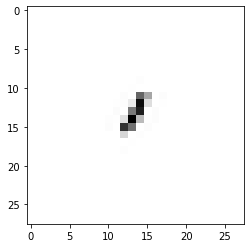

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

# visualisation

#### heterogeneity
- federated data is usually non i.i.d due to user specific usage patterns
- there might be data paucity for some clients while, enough data for some other clients
- in real production federated environment, data inspection is not possible for obv reasons

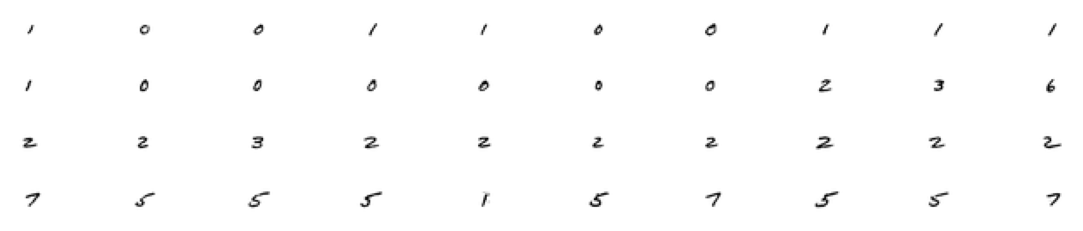

In [ ]:
## Example MNIST digits for a client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1


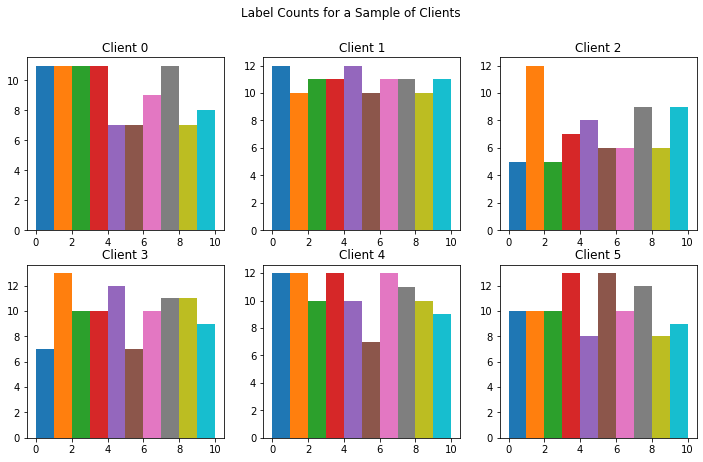

In [ ]:
# #examples for each Client
f = plt.figure(figsize=(12, 7)) 
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


- mean image for each label for a Client
- mean would result accordingly accounting the noise pixels too

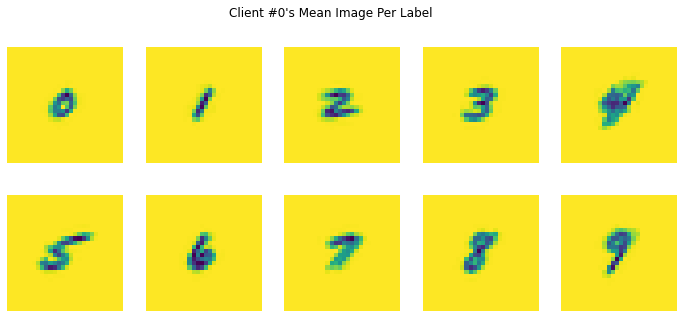

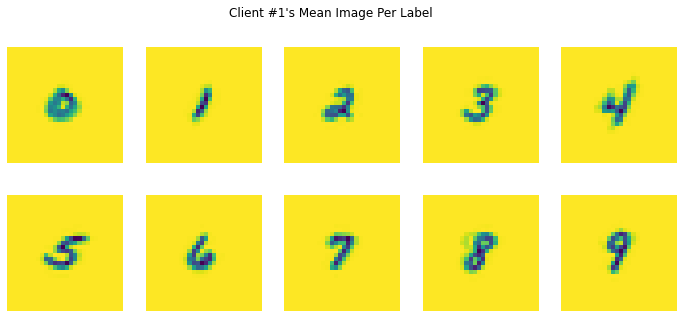

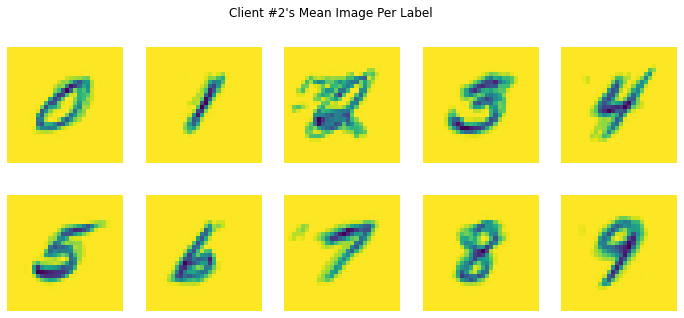

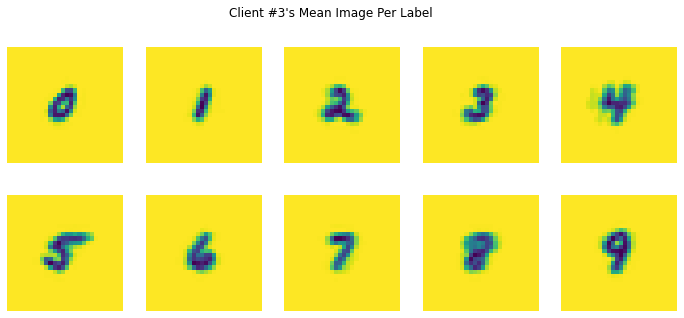

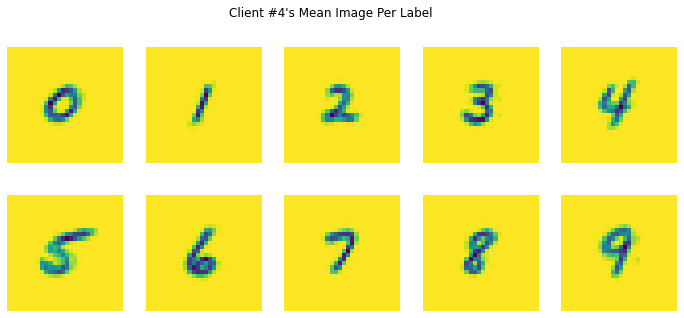

In [ ]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')


### Preprocessing

In [ ]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


In [ ]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))
sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[2],
                     [1],
                     [5],
                     [7],
                     [1],
                     [7],
                     [7],
                     [1],
                     [4],
                     [7],
                     [4],
                     [2],
                     [2],
                     [5],
                     [4],
                     [1],
                     [1],
                     [0],
                     [0],
                     [9]], dtype=int32))])

constructs a list from users for input to a training round

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]


- typically, among all the users, a small set of them is actually available to provide data for model training
- for obvious reasons, it takes enough time to achieve convergence
- with this dataset, we take a small set of users for training; also, running the algorithm for that long to converge is unnecessary
- instead of randomly shuffling the subset for each round, we take same set(intentionally obtaining high variance i.e. overfitting)

In [ ]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))


Number of client datasets: 10
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


### Model training
- keras is best high-level model API for TensorFlow, models of which thru `tff.learning.from_keras_model` are used in TFF
- though, `tff.learning` provides a low-level interface, minimal functionality
- directly implementing from scratch using `tf.keras.layers`, allows max customization

1. Model variables, forward pass and metrics
    - data structure including variables like *weights*, *bias* to be trained
    - variables holding cumulative stats *loss_sum*, *accuracy_sum* and *num_examples*

In [ ]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')


In [ ]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))


2.  forward pass method that computes loss, emits predictions, and updates the cumulative statistics for a single batch of input data

In [ ]:
def predict_on_batch(variables, x):
  return tf.nn.softmax(tf.matmul(x, variables.weights) + variables.bias)

def mnist_forward_pass(variables, batch):
  y = predict_on_batch(variables, batch['x'])
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions


In [ ]:
## local metrics

# returns the unfinalized metric values eligible to be aggregated to the server in a federated learning process
def get_local_unfinalized_metrics(variables):
  return collections.OrderedDict(
      num_examples=[variables.num_examples],
      loss=[variables.loss_sum, variables.num_examples],
      accuracy=[variables.accuracy_sum, variables.num_examples])


# returns an OrderedDict of tf.functions with the same keys
# takes in the metric's unfinalized values and computes the finalized metric
def get_metric_finalizers():
  return collections.OrderedDict(
      num_examples=tf.function(func=lambda x: x[0]),
      loss=tf.function(func=lambda x: x[0] / x[1]),
      accuracy=tf.function(func=lambda x: x[0] / x[1]))


in `tff.learning.build_federated_averaging_process` API, the default value for metrics_aggregator is `tff.learning.metrics.sum_then_finalize`, which first sums the unfinalized metrics from `CLIENTS`, and then applies the metric finalizers at `SERVER`.

3. Constructing instance of `tff.learning.Model`
    - all states must be captured as TensorFlow variables, as TFF doesnt use python at runtime
    - model with declared input format
    - wrap all logics as `tf.learning` to ensure serialization

In [ ]:
from typing import Callable, List, OrderedDict

class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def predict_on_batch(self, x, training=True):
    del training
    return predict_on_batch(self._variables, x)

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_unfinalized_metrics(
      self) -> OrderedDict[str, List[tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to unfinalized values."""
    return get_local_unfinalized_metrics(self._variables)

  def metric_finalizers(
      self) -> OrderedDict[str, Callable[[List[tf.Tensor]], tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to finalizers."""
    return get_metric_finalizers()

  @tf.function
  def reset_metrics(self):
    """Resets metrics variables to initial value."""
    for var in self.local_variables:
      var.assign(tf.zeros_like(var))


4. Simulating federated training
    - use constructor of new model
    - use two federated computations iteratively

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(MnistModel,  client_optimizer_fn = (lambda: tf.keras.optimizers.SGD(learning_rate=0.02)))


TypeError: ignored

In [ ]:
state = iterative_process.initialize()


In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))


In [ ]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))


### Evaluation
- average metrics over all batches of data across all clients concerns about overfitting the user data
- as training is done locally over single and similar batch of data, thus local accuracy will approach to 1
- this implies that the training is just 'progressing'


---

- to perform proper eval on federated data, another federated computation is created using `tff.learning.build_federated_evaluation`

In [ ]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

# signature type
print(evaluation.type_signature.formatted_representation())
    

- not returning server state, its stateless as eval doesnt modify model
- eval needs only model, not anything else from server
`SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS`

In [ ]:
# invoking evaluations
train_metrics = evaluation(state.model, federated_train_data)
str(train_metrics)


In [ ]:
# re-running on compiled sample of federated data from same sample of users, but distinct held-out dataset
federated_test_data = make_federated_data(emnist_test, sample_clients)
len(federated_test_data), federated_test_data[0]


In [ ]:
test_metrics = evaluation(state.model, federated_test_data)
str(test_metrics)
